## Import librararies and fix image size

In [1]:
import random
import requests
import os
import warnings

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

IMAGE_SIZE = (224,224)

## EDA

In [2]:
training_data=pd.read_csv('./train.csv')
training_data.head(5)

id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
1       104169  
2        37914  
3       102140  
4         2474

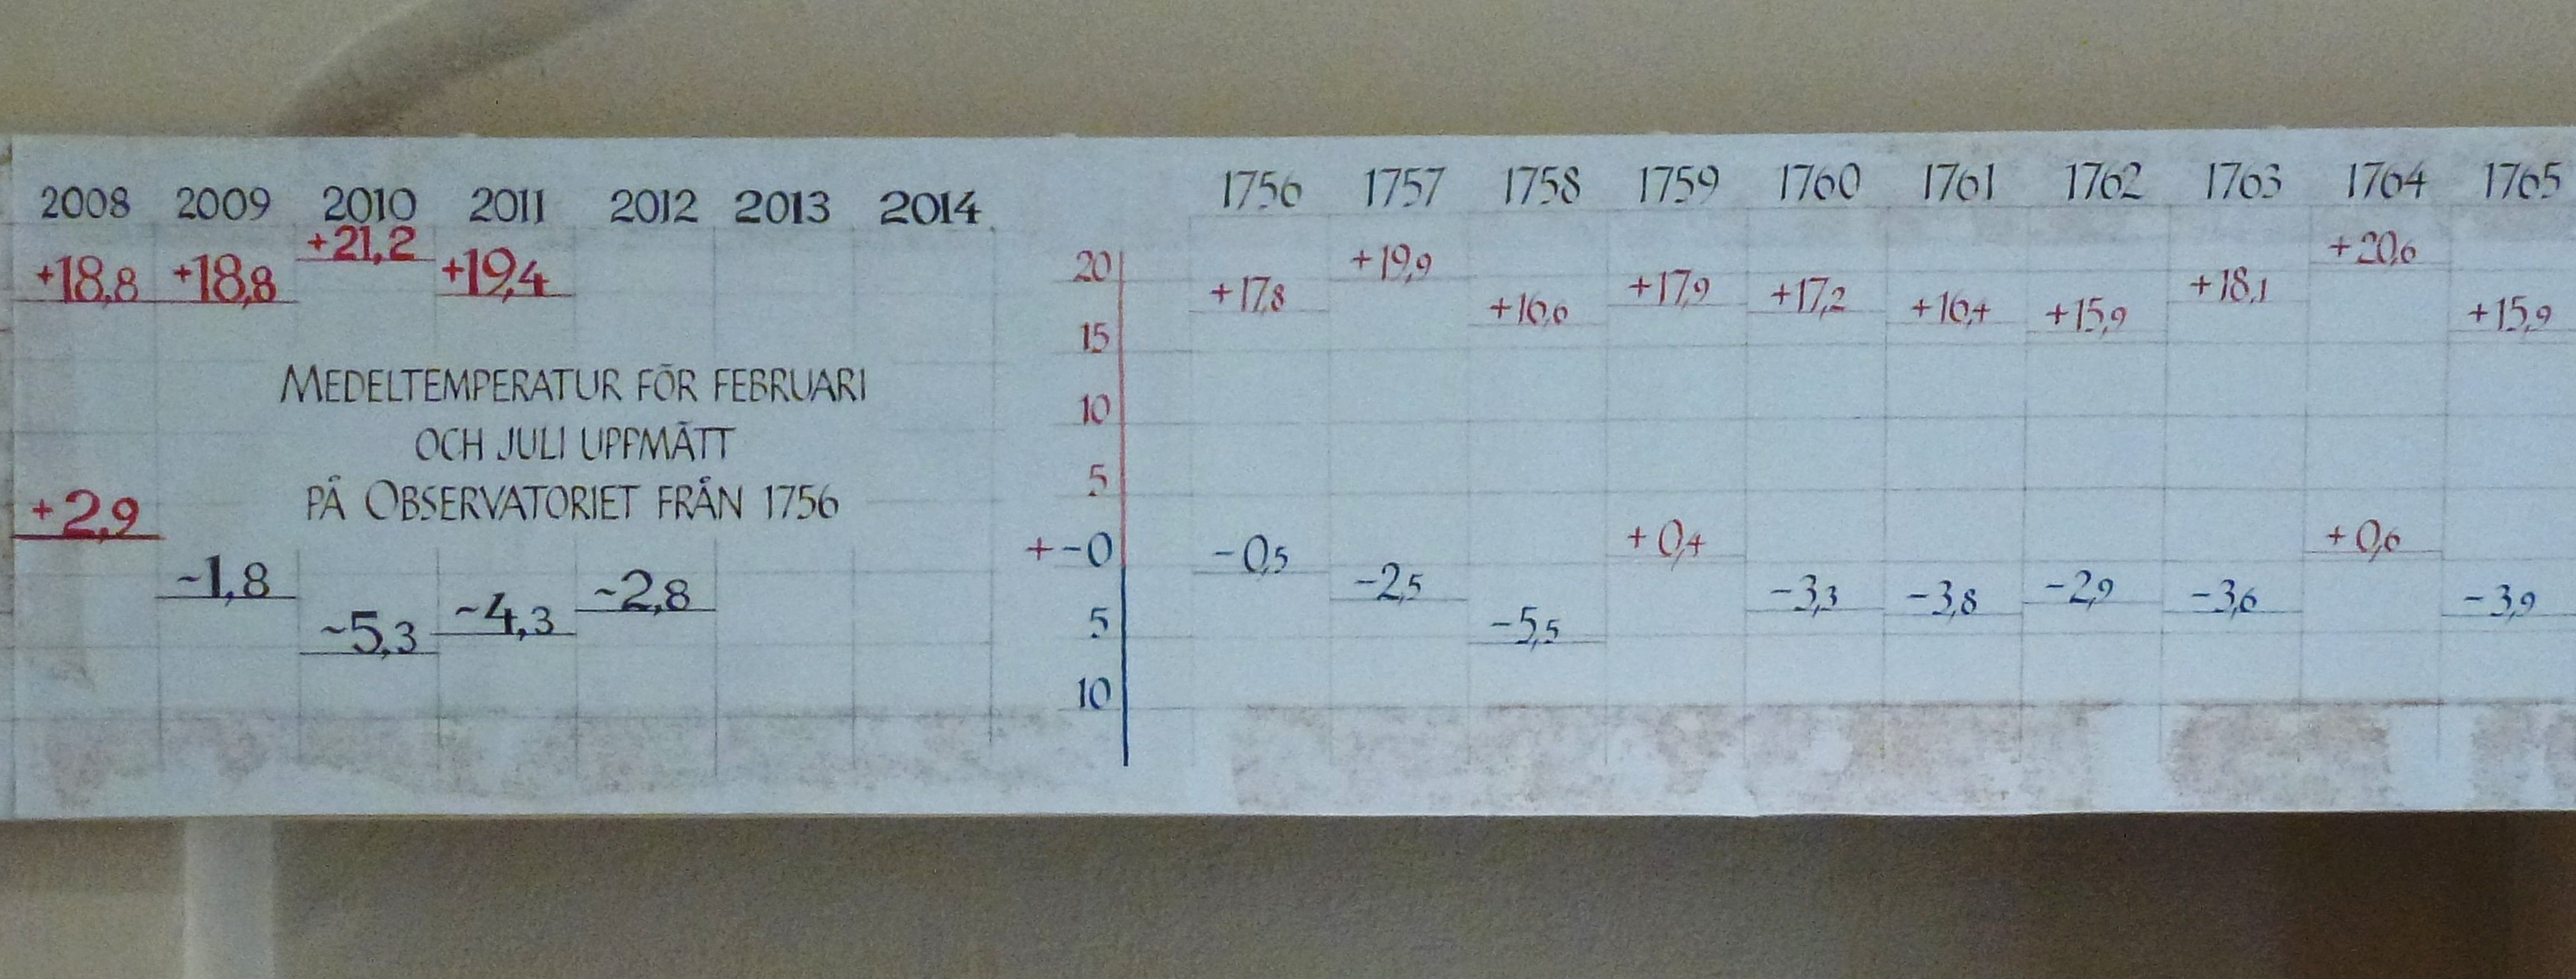

In [3]:
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(training_data['url'][0], headers=headers)
img = Image.open(BytesIO(response.content))
img

In [4]:
training_data['landmark_id'].value_counts()

landmark_id
138982    10247
62798      4333
177870     3327
176528     3243
192931     2627
          ...  
141849        1
50554         1
18724         1
53188         1
59881         1
Name: count, Length: 203094, dtype: int64

Text(0, 0.5, 'Landmarks')

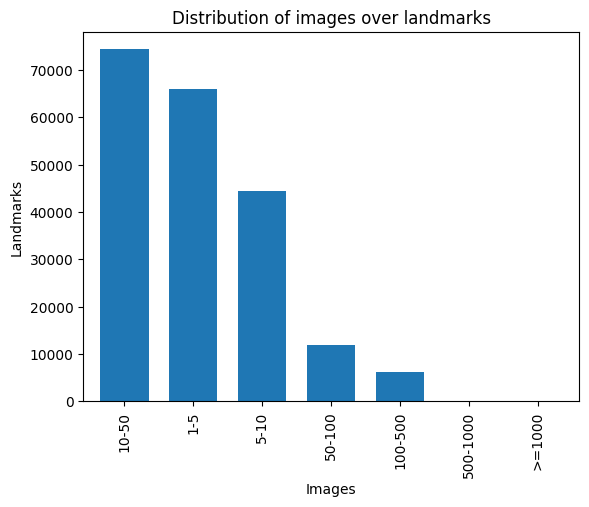

In [5]:
ranges = ['1-5','5-10','10-50','50-100','100-500','500-1000','>=1000']
pics_count = pd.DataFrame(training_data['landmark_id'].value_counts().reset_index())
    
# Create a column where to group the number of images in each class
pics_count['range'] = np.where(pics_count['count']>=1,'1-5',0)
pics_count['range'] = np.where(pics_count['count']>=5,'5-10',pics_count['range'])
pics_count['range'] = np.where(pics_count['count']>=10,'10-50',pics_count['range'])
pics_count['range'] = np.where(pics_count['count']>=50,'50-100',pics_count['range'])
pics_count['range'] = np.where(pics_count['count']>=100,'100-500',pics_count['range'])
pics_count['range'] = np.where(pics_count['count']>=500,'500-1000',pics_count['range'])
pics_count['range'] = np.where(pics_count['count']>=1000,'>=1000',pics_count['range'])

pics_count['range'].value_counts().reset_index()
pics_count['range'].value_counts().plot(kind = 'bar', width = 0.7)
plt.title('Distribution of images over landmarks')
plt.xlabel('Images')
plt.ylabel('Landmarks')

## Sampling Data

In [6]:
# Select 100 classes containing between 10 and 50 images
sample_list = pics_count[pics_count['range']=='10-50'][0:100]
data_sample = training_data[training_data['landmark_id'].isin(sample_list.index)]
data_sample.head(5)

id                                                url  \
11497  c83bc2afe52cd90f  https://upload.wikimedia.org/wikipedia/commons...   
11699  58b50841cd260beb  https://upload.wikimedia.org/wikipedia/commons...   
12139  c098ec4f394b8069  https://upload.wikimedia.org/wikipedia/commons...   
14824  0cc1d924de8a77fa  http://upload.wikimedia.org/wikipedia/commons/...   
15836  5d992a514c1c2aae  https://upload.wikimedia.org/wikipedia/commons...   

       landmark_id  
11497        18511  
11699        18523  
12139        18477  
14824        18456  
15836        18509

In [7]:
# Reorder sub-sample classes from 0 to 9
old_classes = list(set(data_sample['landmark_id']))
new_classes = list(range(100))
data_sample['landmark_id'] = data_sample['landmark_id'].replace(to_replace=old_classes, value=new_classes)
data_sample.head(5)

id                                                url  \
11497  c83bc2afe52cd90f  https://upload.wikimedia.org/wikipedia/commons...   
11699  58b50841cd260beb  https://upload.wikimedia.org/wikipedia/commons...   
12139  c098ec4f394b8069  https://upload.wikimedia.org/wikipedia/commons...   
14824  0cc1d924de8a77fa  http://upload.wikimedia.org/wikipedia/commons/...   
15836  5d992a514c1c2aae  https://upload.wikimedia.org/wikipedia/commons...   

       landmark_id  
11497           79  
11699           91  
12139           45  
14824           24  
15836           77

## Split betweem training, validation and test dataset (75%,20%,5%)

In [8]:
def dataframe_split(dataframe, validation_size, test_size):    
    dataframe, test_df = train_test_split(dataframe, test_size=test_size)

    training_df = pd.DataFrame(columns = ['id','url','landmark_id'])
    validation_df = pd.DataFrame(columns = ['id','url','landmark_id'])
    random.seed(7)   

    # Split the datasets class by class
        # 'cc' stands for current class
    for cc_landmark_id in set(dataframe['landmark_id']):
        cc_data = dataframe[(dataframe.landmark_id == cc_landmark_id)]
        i = 0
        cc_images =[]
        while i < len(cc_data.id):
            cc_images.append(cc_data.id.iloc[i])  # List of all the images for the Current Class
            i += 1
        
        # Randomly pick a sample of images for test and get the remaining images for training
        cc_validation_images = random.sample(cc_images,int(validation_size*len(cc_images)))  
        cc_training_images = list(set(cc_images) - set(cc_validation_images)) 
        
        # Dataset creation from the Image id's
        cc_validation_df = dataframe[dataframe.id.isin(cc_validation_images)]
        cc_training_df = dataframe[dataframe.id.isin(cc_training_images)]
        
        # Add to the whole datasets
        validation_df = pd.concat([validation_df, cc_validation_df], axis=0) 
        training_df = pd.concat([training_df, cc_training_df], axis=0)
    
    return training_df, validation_df, test_df

In [9]:
training_data, validation_data, test_data = dataframe_split(data_sample, validation_size=0.2, test_size=0.05)

In [10]:
training_data.head()

id                                                url  \
935895   0e341f2185d9e823  https://upload.wikimedia.org/wikipedia/commons...   
1986657  436a60c6e34ebfca  https://upload.wikimedia.org/wikipedia/commons...   
485402   1e7f4f57c58e2c9e  https://upload.wikimedia.org/wikipedia/commons...   
3519000  9bdf3713f6f0595a  https://upload.wikimedia.org/wikipedia/commons...   
1641470  25d9902f561ea2c6  https://upload.wikimedia.org/wikipedia/commons...   

        landmark_id  
935895            0  
1986657           0  
485402            0  
3519000           0  
1641470           1

In [11]:
print ('Training set length : '+str(len(training_data)))
print ('Validation set length : '+str(len(validation_data)))
print ('Test set length : '+str(len(test_data)))

Training set length : 1304
Validation set length : 277
Test set length : 84


In [12]:
# Reset indices 
training_data.reset_index(inplace=True)
validation_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

## Download and store images

In [13]:
headers = {'User-Agent': 'Mozilla/5.0'}
def images_download_store(dataset,data_folder):
    
    landmarks_ids = pd.DataFrame(dataset.landmark_id.value_counts())
    landmarks_ids.reset_index(inplace=True)
    landmarks_ids.columns = ['landmark_id','count']
    
    # Create Landmark's folders
    i=0
    while i < len(dataset):
        landmark = str(dataset.landmark_id.iloc[i])
        if not os.path.exists('./Data/' + data_folder + '/'+ landmark):
            os.makedirs('./Data/' + data_folder + '/'+ landmark)
        i+=1
    
    # Download Images
    i=0
    for url in dataset['url']:  
        if os.path.exists('./Data/' + data_folder + '/' + str(dataset['landmark_id'].iloc[i]) + '/'+ str(dataset['id'].iloc[i])+ '.jpg'):
            i+=1
            continue
        try:
            response = requests.get(url, stream=True, headers=headers)
            image = Image.open(BytesIO(response.content))
            image = image.resize(IMAGE_SIZE, Image.ANTIALIAS)
            image.save('./Data/' + data_folder + '/' + str(dataset['landmark_id'].iloc[i]) + '/'+ str(dataset['id'].iloc[i])+ '.jpg')
            del response
        except:
            pass
        i+=1
        if(i%100==0):
            print(str(i)+' images downloaded')   
    print ('Images downloaded')

In [14]:
images_download_store(training_data,'Training_Data')
print ('Training Images Downloaded')
images_download_store(validation_data,'Validation_Data')
print ('Validation Images Downloaded')
images_download_store(test_data,'Test_Data')
print ('Test Images Downloaded')

100 images downloaded
200 images downloaded
300 images downloaded
400 images downloaded
500 images downloaded
600 images downloaded
700 images downloaded
800 images downloaded
900 images downloaded
1000 images downloaded
1100 images downloaded
1200 images downloaded
1300 images downloaded
Images downloaded
Training Images Downloaded
100 images downloaded
200 images downloaded
Images downloaded
Validation Images Downloaded
Images downloaded
Test Images Downloaded


##  Delete broken images and save the final data & labels

In [15]:
train_data_dir = './Data/Training_Data'
validation_data_dir = './Data/Validation_Data'
test_data_dir= './Data/Test_Data'

num_classes = 10

final_train_data_dir = './FinalData/Training_Data'
final_validation_data_dir = './FinalData/Validation_Data'
final_test_data_dir= './FinalData/Test_Data'

train_labels_file = './Labels/training_labels.npy'
validation_labels_file = './Labels/validation_labels.npy'
test_labels_file = './Labels/test_labels.npy'

In [16]:
def count_files_in_dir(dir):
    return sum([len(files) for r, d, files in os.walk(dir)])

In [17]:
count_files_in_dir(test_data_dir)

80

In [18]:
def get_labels(dir):
    i = 0
    labels = []
    while i < num_classes:
        for root, dirs, files in os.walk(dir +'/'+ str(i)):  # Loop through folders
            for pic in files:
                try:
                    with Image.open(dir +'/'+ str(i) +'/'+pic):
                        labels.append(str(i))
                except:
                    os.remove(dir +'/'+ str(i) +'/'+pic) # Remove broken files
                    print('Broken image ' + pic + ' removed successfully')
        i += 1
    print (dir + ' : ' + str(len(labels)) + ' Images')
    return labels

In [19]:
train_labels = get_labels(train_data_dir)
validation_labels = get_labels(validation_data_dir)
test_labels = get_labels(test_data_dir)

./Data/Training_Data : 61 Images
./Data/Validation_Data : 10 Images
./Data/Test_Data : 11 Images


In [20]:
def save_final_files(dir, orig_dir):
    i=0
    images = 0
    while i < num_classes:
        if not os.path.exists(dir + '/'+ str(i)):
            os.makedirs(dir + '/'+ str(i))
        for root, dirs, files in os.walk(os.path.join(orig_dir, str(i))):
            for pic in files:
                file_path = os.path.join(root, pic)
                image = Image.open(file_path)
                image.save(os.path.join(dir, str(i), pic))
                images += 1
        i += 1
    print (dir + ' : ' + str(images) + ' Images')

In [21]:
save_final_files(final_train_data_dir, train_data_dir)
save_final_files(final_validation_data_dir, validation_data_dir)
save_final_files(final_test_data_dir, test_data_dir)

./FinalData/Training_Data : 61 Images
./FinalData/Validation_Data : 10 Images
./FinalData/Test_Data : 11 Images


In [22]:
count_files_in_dir(final_train_data_dir)

61

In [23]:
os.makedirs(os.path.dirname(train_labels_file), exist_ok=True)
with open(train_labels_file, 'wb') as file:
        np.save(file, train_labels)

In [24]:
os.makedirs(os.path.dirname(validation_labels_file), exist_ok=True)
with open(validation_labels_file, 'wb') as file:
        np.save(file, validation_labels)

In [25]:
os.makedirs(os.path.dirname(test_labels_file), exist_ok=True)
with open(test_labels_file, 'wb') as file:
        np.save(file, test_labels)